# Introduction: Data Sources and Stylized Facts

In this notebook we examine some available datasources for the UK intraday power market in order to be able to create a simulated environment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



plt.style.use('seaborn')

In [2]:
df_wap_bal = pd.read_csv('strategy_data_lobniv.csv', index_col = 0, parse_dates=True)
raw_quotes = pd.read_pickle('outfile')
quotes = pd.DataFrame(raw_quotes)
quotes.columns = ['delivery_time', 'order_book']
quotes.set_index('delivery_time', drop=True, inplace=True)
quotes.loc['2022-07-28 00:00:00+00:00'].order_book.drop(columns = 'delivery_time', inplace=True)

## Brief description of data sources

- Dataframe df_wap_bal contains: 
    - Weighted average price data
    - Net Imbalance Volume
    - Imbalance Price
    
- Dataframe quotes contains:
    - Limit Order book at level = 1 (Market Orders)
    
    
At every delivery time a tradable intraday contract closes. The intraday power market is organised in 48 tradable daily contract of half an hour, we are not considering blocks of contracts which are also tradable contracts. In the df_wap_bal, there are several weighted average prices. These corresponds to one hour up to four hour before the delivery time. For simplicity we will be considering those contracts only one hour before delivery.

In [3]:
df_wap_bal = df_wap_bal[['wap1', 'niv', 'imb']]
quotes['niv'] = df_wap_bal.niv
quotes['imb'] = df_wap_bal.imb

# Stylized Facts

Power prices reacts to the Net Imbalance Volume (NIV). The latter is an information given from the UK power grid to say wether the UK electric system is short or has too much of power. When the system is short of power, the NIV becomes positive, conversely when the system has too much of power then NIV becomes negative. The magnitude of the NIV will set the imbalance price, which is understood to be the cash out of each single tradable half-hourly contracts. We should show a plot of the wap prices, the NIV and the imbalance price time series.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

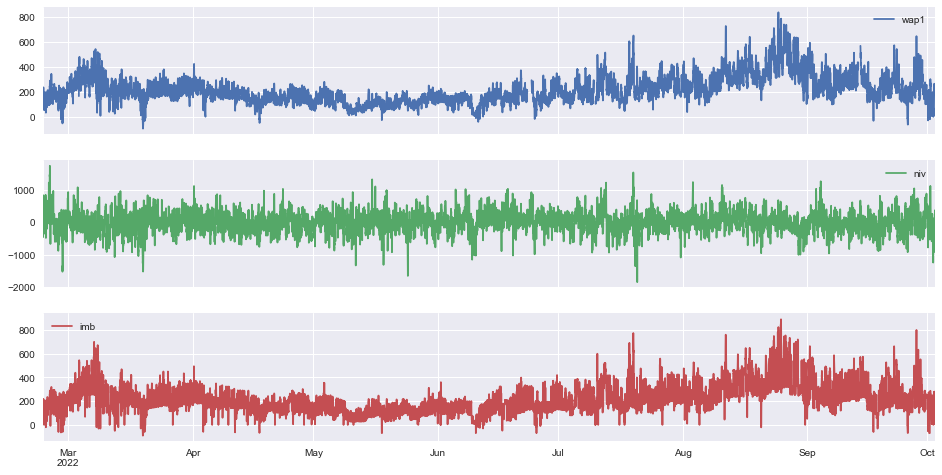

In [4]:
df_wap_bal.plot(figsize = (16,8), subplots = True)

From a first glance we can see that the imbalance price and wap1 time series show some cointegration. The NIV time series looks stationary, with a high level of noise. The latter, from the system point of view, should be a mean reverting time series since the grid will be balanced if and only if the NIV is close to zero (or zero), therefore the grid takes balancing action to revert the process to zero. It is not hard to see that the NIV is a stationary time series performing ADF tests and KPSS tests, and moreover it is a mean reverting process (this can be proved with the Hurst exponent). 

## Stylized Market Facts

The NIV sets the direction of the price. Because, of the cointegration of the imbalance price time series and the wap1 time series, then the premium defined as imbalance price minus wap1, also follows othe direction of the NIV. That means that the NIV direction will essentially set the position of the trade to be made in the market. That means, if the sign of NIV is negative then the position is short, and if the sign of the NIV is positive then the position is long.


Below, we show the ideal scenario where the trader knows all the NIV directions and makes profit on the premium.

Terminal Wealth: 445087.75
Return per MW: 41.69


<AxesSubplot:title={'center':'Ideal Premium Trader'}>

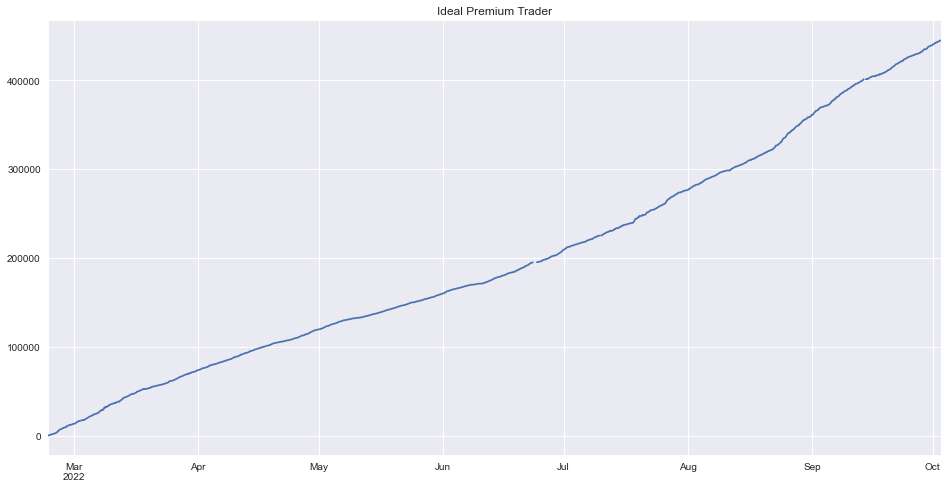

In [5]:
backtest = df_wap_bal.copy()

backtest['premium'] = df_wap_bal.imb.sub(df_wap_bal.wap1)
backtest['niv_direction'] = np.sign(df_wap_bal.niv)
backtest['strategy_returns'] = backtest.niv_direction * backtest.premium
backtest['total_returns'] = backtest.strategy_returns.cumsum()

print('Terminal Wealth: {:.2f}'.format(backtest.total_returns[-1]))
print('Return per MW: {:.2f}'.format(backtest.total_returns[-1]/backtest.shape[0]))


backtest.total_returns.plot(figsize = (16,8), title = 'Ideal Premium Trader')

## Important Remark:

The above is an ideal situation, indeed the trader does not know the NIV in advance when he is trading in a current settlement period. The latest information the trader has is the previous hour NIV. In that case, a more realistic backtest will be given in the following:

In [6]:
def backtest_niv_slider(lag: int) -> pd.DataFrame:
    
    backtest_wap = df_wap_bal.copy()

    backtest_wap['premium'] = backtest_wap.imb.sub(backtest_wap.wap1)
    backtest_wap['niv_direction'] = np.sign(backtest_wap.niv.shift(lag))
    backtest_wap['strategy_returns'] = backtest_wap.niv_direction * backtest_wap.premium
    backtest_wap['total_returns'] = backtest_wap.strategy_returns.cumsum()

    print('Terminal Wealth: {:.2f}'.format(backtest_wap.total_returns[-1]))
    print('Return per MW: {:.2f}'.format(backtest_wap.total_returns[-1]/backtest_wap.shape[0]))


    backtest_wap.total_returns.plot(figsize = (16,8), title = 'Delayed Premium Trader')
    
    return backtest_wap
    

Terminal Wealth: 47849.90
Return per MW: 4.48


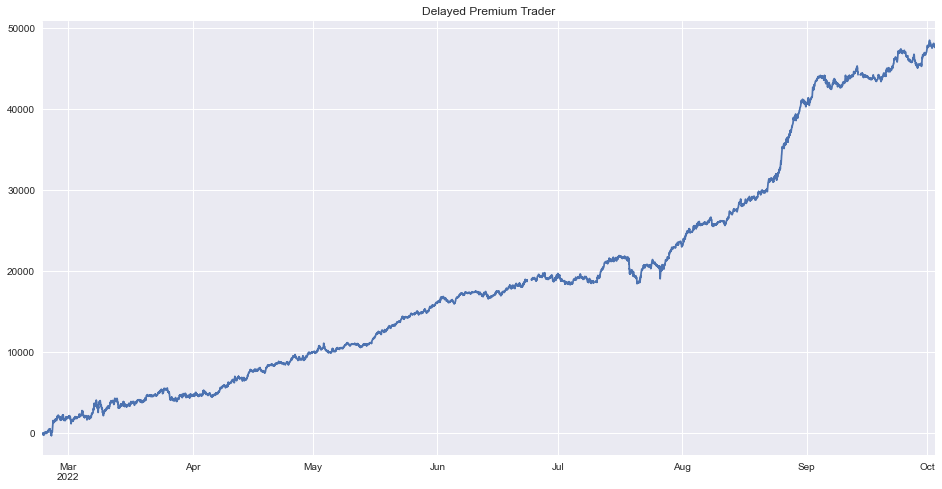

In [7]:
# Trading knowing the last niv information

bkt_wap = backtest_niv_slider(lag=2)

Terminal Wealth: 16696.08
Return per MW: 1.56


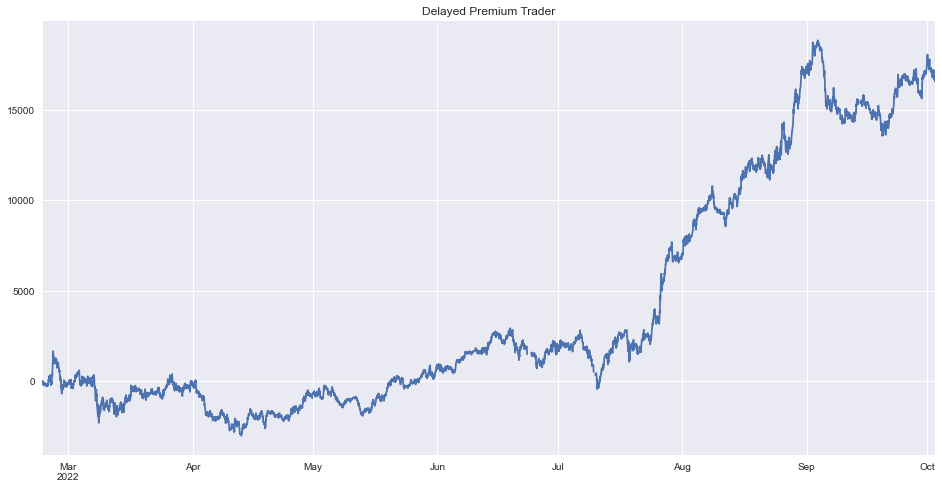

In [8]:
# Trading knowing the last 2 niv information

bkt_wap = backtest_niv_slider(lag=4)

In both cases the strategy returns to be profitable if the trader keeps bidding on the NIV "old" information believing that the trend will persist. Nevertheless, this scenario is still somewhat ideal since the weighted average prices are "fictious" prices, that is when trading in the market we might not find any of those prices or we don't have the possibility to get "lifted" or "hit" at those prices. Moreover, the trader could also liquidate its position in the market, before going to balance. This happens in most of rational traders when the speculation of the NIV is uncertain. Moreover, when the NIV is not known, tipycaly there are before delivery two imbalance prices, the latter will settle based on the magnitude and the direction of the NIV. 

**Example**. Suppose the market is trading for a specific contract at 180 pounds. The direction of the NIV is still uncertain, but the last hour NIV procured 250MW upwards with an imbalance price of 200 pounds. If the trader assumes that this will repeat, before the imbalance price settles there are two imbalance prices, so as of now if NIV will be around 250MW upwards then the imbalance price is 200 pounds, else if the NIV procured is around -100 MW then the imbalance price will be more likely 60 pounds. So, ifthe trader assumes that the NIV will keep going up then he will buy a few megawatts in the market around 180 pounds. But, will it be convenient to take this position to imbalance? In this case not quite, because of the following:

- If the system regulates up premium is: 200 - 180 = 20 pounds.
- If the system regulates down premium is: 60 - 180 = -120 pounds.

So the above is quite a bad bet, meaning that the trader could lose more than it could win. Therefore, in this case the trader aims to close the opened position in the market before delivery to eventually make a profit of 5 to 20 pounds.

## A more realistic approach

In order to operate correctly in the market, a trader must know the limit order book. So in this part it is worth to spend a few words on how an order book works and how a trade is made in the market.

**definition**. An *order* is a request to either buy or sell an asset. At a minimum an order typically contains the following:

- Asset identifier (e.g., ticker symbol);
- side (e.g., buy or sell),
- quantity,
- type (market or limit),
- time in force (Immediate or cancel, Day, or Good-Til-Cancelled)

With a limit order, by definition, the trader must specify a limit price. For buy orders this represents the highest price the buyer is willing to pay; for sell orders, it represents the lowest price the seller is willing to accept. Market orders, on the other hand, indicate the trader is willing to trade at the prevailing market price.

An order is sent to a trading venue for execution. For our purposes, a trading venue is defined as the destination - physical or virtual - where buyers and sellers trade with one another.

**definition**. An *order book* is the collection of orders submitted to a trading venue. The buyer side of an order book is referred to as the *bid side*, and the seller side of the market is either referred to as either *ask side* or *offer side*. 

**definition**. A *quote* is similar to an order. Both represent buying or selling interest. However, quotes are special in that they are disseminated, or "posted", to the public by either a trading venue or a dealer or market maker. 

Similarly to an order book, the buy portion of a quote is referred to as bid, and the sell portion is referred to as an offer or ask. The price difference between the best bid and offer prices is referred to as the bid-ask spread. The quote prices are typically associated with a particular size, which indicates how much quantity the dealer is willing to transact at those prices. The quantitity is referred to as the size or depth of the quote. In general the bid and offer prices will differ, with the id price being no greater than the offer price, which is equivalent to saying the spread should never be negative. 

A **trade** occurs when a buy order (or bid quote) executes against a sell order (or ask quote). Priority rules dictate who is next in line to trade when there are multiple orders available at a given venue. Most markets prioritize orders on the basis of price first - the participant with the highest bid or lowest offer trades first. If there are multiple orders that are tied at a price, then the secondary priority rules apply. This mechanism is called "walk the book". 



If a trader wants to buy immediately in the market a specific asset it will send a buy order at the best ask price, conversely if a trader wants to sell immediately in the market a specific asset it will send a sell order at the best bid price. Nevertheless, if the trader is more patient on buy the asset it will post a quote on the bid side at some specific level, or if he is patient on selling it will post a quote on the ask side at some specific level of the order book at that time.


Below we give an example of the first layer of the Limit Order Book, i.e. market orders.

In [9]:
quotes.loc['2022-07-28 00:00:00+00:00'].order_book.dropna().head(10)

,bid_size,bid,ask,ask_size
time,,,,
2022-07-27 23:13:25,5.5,225.00,268.30,1.0
2022-07-27 23:13:26,4.9,225.02,268.30,1.0
2022-07-27 23:13:40,4.9,225.02,249.89,1.0
2022-07-27 23:13:49,4.9,225.02,244.89,1.0
2022-07-27 23:13:58,4.9,225.02,244.89,1.0
2022-07-27 23:13:59,0.3,225.03,250.00,1.0
2022-07-27 23:14:13,0.3,225.03,250.00,1.2
2022-07-27 23:14:17,0.1,225.03,245.00,25.0
2022-07-27 23:14:36,0.1,225.03,245.00,25.0


So in order to make profit with the previous strategy, we should take into account that the trader should send market orders or post a quote if the trader believes that there is a probability of getting liquidated in the market.

For every settlement period (SP) or half hourly contract, the trader can experience price fluctuations, therefore if the trader speculates correctly on the direction then the trader can make profits in the market, without necessarily leave a position for balancing. We make an example of how a trader that is willing to assume the trend of NIV regulation could make some profit in the market.

In [10]:
exa = quotes.copy()
exa_df = exa.loc['2022-08-14 10:00:00': '2022-08-14 11:00:00'].copy()
exa_df['lag2_niv'] = exa_df.niv.shift(2)
exa_df['lag2_imb'] = exa_df.imb.shift(2)

exa_df.dropna(inplace = True)

exa_df

,order_book,niv,imb,lag2_niv,lag2_imb
delivery_time,,,,,
2022-08-14 11:00:00+00:00,bid_size bid ask ...,57.75,343.0,203.26,430.0


In [11]:
def buy_best_ask(level: int, size: float = 1) -> (float, float, float):
    store_trade = level
    in_position = True
    return store_trade, order_book.ask.iloc[level] * size, in_position

def sell_best_bid(level: int, size: float = 1) -> (float, float, float):
    store_trade = level
    in_position = True
    return store_trade, order_book.bid.iloc[level] * size, in_position

def is_closing_time(delivery_time: str, timestamp: str) -> bool:
    time_delta = (pd.to_datetime(delivery_time) - pd.to_datetime(timestamp)).total_seconds()/60
    return time_delta <= 30.

def close_position(position: int, level: int):
    
    if position == -1:
        store_trade, traded_price, in_position = buy_best_ask(level)
        
    elif position == 1:
        store_trade, traded_price, in_position = sell_best_bid(level)
        
        
    return store_trade, traded_price, in_position

def is_good_bet(position:int, traded_price:float, lagged_imb:float):
    cash_out = position * (lagged_imb - traded_price)
    return cash_out >= 40
    

In [12]:
delivery_time = '2022-08-14 11:00:00'
order_book = exa_df.loc[delivery_time].order_book.dropna()
lagged_niv = float(exa_df.lag2_niv)
lagged_imb = float(exa_df.lag2_imb)

premium = 10 # The trader aims to make at least 10 pounds in the market
in_position = False # boolean variable to check if the trader has a position or not

transaction_history = {'timestamp': [], 'traded_price': [], 'position': []} # keep trace of trans.
position = 0

if lagged_niv > 0:    # The trader assumes that the trend of the niv persists, so it considers one 
                      # hour lag
    
        
    for level in range(len(order_book)):
        
        if not in_position:
            
            store_trade, traded_price, in_position = buy_best_ask(level)
            position = 1
            
            transaction_history['timestamp'].append(order_book.index[store_trade])
            transaction_history['traded_price'].append(traded_price)
            transaction_history['position'].append(position)
            
            
            
        elif (in_position) & (traded_price < order_book.bid.iloc[level] - premium):
            store_trade, traded_price, in_position = buy_best_ask(level)
            position = -1
            in_position = False
            
            transaction_history['timestamp'].append(order_book.index[store_trade])
            transaction_history['traded_price'].append(traded_price)
            transaction_history['position'].append(position)
    
    
        
        elif (is_closing_time(delivery_time, order_book.index[level])): # if there is no time left
            
            if position != 0:
                
                if is_good_bet(position, traded_price, lagged_imb): # decides if could go to balance
                    position = position
                    break
                
                else:
                    # If there is no premium in the balance then liquidate all positions in the market
                    # before delivery time.
                    
                    store_trade, traded_price, in_position= close_position(position, level)
                    position = 0
                    
                    transaction_history['timestamp'].append(order_book.index[store_trade])
                    transaction_history['traded_price'].append(traded_price)
                    transaction_history['position'].append(position)

                    break

bkt = pd.DataFrame(transaction_history)
bkt['returns'] = bkt.traded_price.shift(1) - bkt.traded_price
if bkt.position.sum() != 0:
    bkt.iloc[-1, bkt.columns.get_loc('returns')] = float(exa_df.imb.values) - bkt.iloc[-1]['traded_price']

bkt['sreturns'] = bkt.position * bkt.returns

print('Trader Return: {:.2f}'.format(bkt.sreturns.sum()))
    

Trader Return: 35.01


**Remark**. The strategy of assuming the last hour balancing price makes sense, but it doesn't take into account the risk of shortfal, namely if the niv will regulate in the opposite direction of its beliefs, then the balancing price may be different. To have access to this kind of data one should consider the physical stack of the power plants or flows that are willing to be activate to produce/reduce power for the system.

# Conclusion.

We can see that there are some stylized facts of the trading mechanism in this particular power market. These stylized facts are indeed profitable. In the next notebook, we divide each single part to see if we can draw some more stylized facts that could potentially allow us to construct an environment for applying reinforcement learning.